# Introduction
____
In this kernel I'll show how to get the data in the proper format to use it on a CNN and make the classification. First let's import the necessary libraries.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
from skimage.io import imread #read images from files
import os
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


Next we create a dataframe using the image's path as the first column and the id as the second column (if you don't understand why that split is being used that way, I suggest that you get one of the paths available and try using `.split('/')[3]...` to see what is going on here. Next we read the labels and merge with our dataframe through their ids, so we know which image corresponds to each label. 

In [2]:
base_tile_dir = '../input/train/'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0])
labels = pd.read_csv("../input/train_labels.csv")
df = df.merge(labels, on = "id")
df.head(10)

,path,id,label
0,../input/train/292faf631c5ff5741bb46b04e4eacce...,292faf631c5ff5741bb46b04e4eacceb272d8c8b,0
1,../input/train/5a61b93a34e2a37869a4e83e964169a...,5a61b93a34e2a37869a4e83e964169ad3d1e3753,0
2,../input/train/139e7bd057aafacf7cce59490104ccf...,139e7bd057aafacf7cce59490104ccf281a3fa98,0
3,../input/train/5adf6b5ce28b15f585b8d53fc8d3716...,5adf6b5ce28b15f585b8d53fc8d3716182026ab4,0
4,../input/train/abf7a7eb3e7bc917e766670eebd7f44...,abf7a7eb3e7bc917e766670eebd7f440c500ee4d,0
5,../input/train/156f6a50526bdfdfae44a804c6fabce...,156f6a50526bdfdfae44a804c6fabce6562482e0,1
6,../input/train/35246d6405f080a57505e2e4d8ec0fa...,35246d6405f080a57505e2e4d8ec0fa9df33e7e3,0
7,../input/train/b2b1c081319ac56e011bfe368fb3033...,b2b1c081319ac56e011bfe368fb30336fa1ddce1,1
8,../input/train/f2f7753410bd17f63f1fb6570e2614d...,f2f7753410bd17f63f1fb6570e2614d6092c2754,1
9,../input/train/3cf3e17777c2b73fe7d11f09857f32c...,3cf3e17777c2b73fe7d11f09857f32c9a418a378,0


Now, before we look at the images, it is important to note that there are LOTS of images and this can easily blow up the kernel's memory if we use all of them in training (considering that we are using a Kaggle's kernel). To avoid this problem and also keep balance in our training data, I'll use 5k examples for each label. 

In [3]:
df0 = df[df.label == 0].sample(5000, random_state = 42)
df1 = df[df.label == 1].sample(5000, random_state = 42)
df = pd.concat([df0, df1], ignore_index=True).reset_index()
df = df[["path", "id", "label"]]
df.sample(10)

,path,id,label
1492,../input/train/22ccc0ccf4cebc29a98e4ab24a70fb2...,22ccc0ccf4cebc29a98e4ab24a70fb23ee862955,0
9631,../input/train/a42624d7dee9c6b26e66f38df741c18...,a42624d7dee9c6b26e66f38df741c1887b498692,1
5148,../input/train/1ed0dace9029ce05b8f38ae5d13c9ca...,1ed0dace9029ce05b8f38ae5d13c9ca67d9cfb9f,1
7347,../input/train/dc4809629cbe04937f0de7ee65ad9db...,dc4809629cbe04937f0de7ee65ad9dbfc99ede24,1
7397,../input/train/13e7e4b3ef7edfffe03e812ef6f2eba...,13e7e4b3ef7edfffe03e812ef6f2ebaa8955cc37,1
136,../input/train/deae57514c59abeb96a15a005d12f50...,deae57514c59abeb96a15a005d12f5053b83fea7,0
4328,../input/train/7aa02d21b8ef77cf0ddf74da3a772a9...,7aa02d21b8ef77cf0ddf74da3a772a97d5a5c65b,0
9169,../input/train/4f856f2ffa913b00c02ca045c60c942...,4f856f2ffa913b00c02ca045c60c9426c0acc01e,1
2182,../input/train/420d275bd770e151458f18423eb4b89...,420d275bd770e151458f18423eb4b8990c1e3da3,0
7121,../input/train/b4be05d4df22e0ed679264b470da07f...,b4be05d4df22e0ed679264b470da07f831e7c941,1


Now that we know that both classes are balanced and how many of them there are, we can start looking at the images. To do so, I'll use imread function imported on the first code chunk.

In [4]:
df['image'] = df['path'].map(imread)
df.sample(3)

,path,id,label,image
2760,../input/train/786b17459879562b56c1d5dd559dae8...,786b17459879562b56c1d5dd559dae8029f0ec77,0,"[[[148, 86, 161], [180, 116, 202], [165, 99, 1..."
7058,../input/train/1412261ec1dc22e29d3749aff2d03db...,1412261ec1dc22e29d3749aff2d03db29cc7e253,1,"[[[239, 228, 232], [209, 197, 201], [228, 213,..."
9076,../input/train/b531f285199a4f724fa6614f20a73de...,b531f285199a4f724fa6614f20a73deacf615a47,1,"[[[208, 144, 171], [170, 105, 135], [179, 116,..."


Great! Now we can see that our images are represented by an array of arrays. To read them, we can make use of either matplotlib or the more computer vision-focused opencv. Here I'll use the first option for simplicity. Let's see two sets of images: one with label 0 and another with label 1.

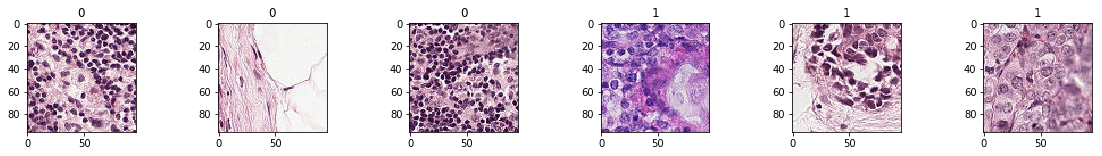

In [5]:
import matplotlib.pyplot as plt

images = [(df['image'][0], df['label'][0]), 
          (df['image'][1], df['label'][1]),
          (df['image'][2], df['label'][2]),
          (df['image'][5000], df['label'][5000]),
          (df['image'][5001], df['label'][5001]),
          (df['image'][5002], df['label'][5002])]

fig, m_axs = plt.subplots(1, len(images), figsize = (20, 2))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(images[ii][0])
    c_ax.set_title(images[ii][1])

Only by looking at the images above I can hardly tell why the three to the right were detected with cancer. Maybe our model can find patterns that we - that don't have any specialized training - can't? Let's create our set of inputs. By using `np.stack` we create a 4-rank tensor: 10000 observations where each one is a 96x96x3 image.

In [6]:
input_images = np.stack(list(df.image), axis = 0)
input_images.shape

(10000, 96, 96, 3)

Now our work is pretty straightforward. We split our input_images in training, validation and testing sets and run them through our model.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils


train_fraction = 0.8

encoder = LabelBinarizer()
y = encoder.fit_transform(df.label)
x = input_images

train_tensors, test_tensors, train_targets, test_targets =\
    train_test_split(x, y, train_size = train_fraction, random_state = 42)

val_size = int(0.5*len(test_tensors))

val_tensors = test_tensors[:val_size]
val_targets = test_targets[:val_size]
test_tensors = test_tensors[val_size:]
test_targets = test_targets[val_size:]

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from tensorflow import set_random_seed

set_random_seed(42)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                               verbose=1, save_best_only=True)
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'elu'))

model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
#working AUC metric for keras from here: 
#https://github.com/keras-team/keras/issues/3230
def auc(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

#---------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP/N

#----------------
# PTA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP/P

from keras.optimizers import SGD
# sgd = SGD(lr = 0.0001, momentum = 0.9)
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 15
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=80, verbose=1, callbacks = [early_stopping, checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 8000 samples, validate on 1000 samples
Epoch 1/15
8000/8000 [==============================] - 9s 1ms/step - loss: 0.8153 - acc: 0.6800 - val_loss: 0.6184 - val_acc: 0.7030

Epoch 00001: val_loss improved from inf to 0.61840, saving model to weights.hdf5
Epoch 2/15
8000/8000 [==============================] - 3s 386us/step - loss: 0.5101 - acc: 0.7595 - val_loss: 0.5621 - val_acc: 0.7440

Epoch 00002: val_loss improved from 0.61840 to 0.56215, saving model to weights.hdf5
Epoch 3/15
8000/8000 [==============================] - 3s 387us/step - loss: 0.4733 - acc: 0.7859 - val_loss: 0.5317 - val_acc: 0.7730

Epoch 00003: val_loss improved from 0.56215 to 0.53172, saving model to weights.hdf5
Epoch 4/15
8000/8000 [==============================] - 3s 390us/step - loss: 0.4767 - acc: 0.7817 - val_loss: 0.5873 - val_acc: 0.7090

Epoch 00004: val_loss did not improve from 0.53172
Epoch 5/15
8000/8000 [==============================] - 

In [10]:
model.load_weights('weights.hdf5')

cancer_predictions =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

test_accuracy = 100*np.sum(np.round(cancer_predictions).astype('int32')==test_targets.flatten())/len(cancer_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 78.2000%


In [11]:
#AUC score
from sklearn.metrics import roc_auc_score
score = roc_auc_score(np.round(cancer_predictions).astype('int32'), test_targets)
score

0.7819437077044253

In [12]:
base_tile_dir = '../input/test/'
test_df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0])

In [13]:
test_df['image'] = test_df['path'].map(imread)

In [14]:
test_images = np.stack(test_df.image, axis = 0)
test_images.shape

(57458, 96, 96, 3)

Using the trained model to make the predictions

In [15]:
predicted_labels =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_images]

In [16]:
predictions = np.array(predicted_labels)
test_df['label'] = predictions
submission = test_df[["id", "label"]]
submission.head()

,id,label
0,0eb051700fb6b1bf96188f36c8e4889598c6a157,0.768174
1,c99d6bc4cee9df4c93a0c3f4138664db59e1e6ef,0.611574
2,2859428095a9d1e6aba4bc135c69b59693b6d02a,0.139849
3,13141967dff006e2e3f65282a02d3faf46ec038f,0.283894
4,ad15cf4e12c953fd5822eec528c55a54fccaeae8,0.809326


In [17]:
#submission
submission.to_csv("submission.csv", index = False, header = True)